In [98]:
import matplotlib.pyplot as plt
import pandas as pd
import keras_tuner as kt
from keras.callbacks import EarlyStopping
import seaborn as sns
from IPython.core.display_functions import display
from IPython.display import Audio
from livelossplot import PlotLossesKeras

import keras
from keras import layers
from keras.models import Sequential

from keras_preprocessing.image import img_to_array

import tensorflow as tf
from keras.layers import *

import os
from tqdm.notebook import tqdm
from pathlib import Path
import shutil


from music_plots import *
from sklearn.metrics import roc_auc_score
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder


<h1> Data management </h1>

In [89]:
tracks_df = load("data/tracks.csv")
genres_df = load("data/genres.csv")
features_df = load("data/features.csv")

In [90]:
tracks_df.head()
genres_df.head()
#features_df.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


In [91]:
track_genres = tracks_df.xs('track', level=0, axis=1)['genre_top'].loc[features_df.dropna().index]
track_genres = track_genres.dropna()
features_df = features_df.loc[track_genres.index]

track_genres

track_id
2         Hip-Hop
3         Hip-Hop
5         Hip-Hop
10            Pop
134       Hip-Hop
           ...   
155315       Rock
155316       Rock
155317       Rock
155318       Rock
155319       Rock
Name: genre_top, Length: 49598, dtype: category
Categories (16, object): ['Blues', 'Classical', 'Country', 'Easy Listening', ..., 'Pop', 'Rock', 'Soul-RnB', 'Spoken']

Rock                   14182
Experimental           10608
Electronic              9372
Hip-Hop                 3552
Folk                    2803
Pop                     2332
Instrumental            2079
International           1389
Classical               1230
Jazz                     571
Old-Time / Historic      554
Spoken                   423
Country                  194
Soul-RnB                 175
Blues                    110
Easy Listening            24
Name: genre_top, dtype: int64


<AxesSubplot:>

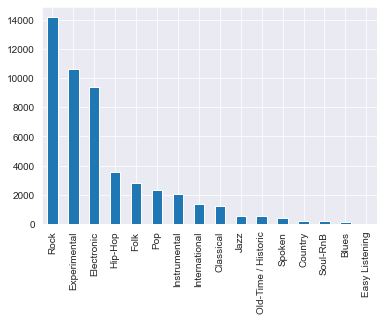

In [92]:
value_counts = track_genres.value_counts()
print(value_counts)
value_counts.plot.bar()

In [93]:
# genres dictionary
genres = {}
index = 0
for i in track_genres.unique():
    genres[i] = index
    index += 1
print(genres)

{'Hip-Hop': 0, 'Pop': 1, 'Rock': 2, 'Experimental': 3, 'Folk': 4, 'Jazz': 5, 'Electronic': 6, 'Spoken': 7, 'International': 8, 'Soul-RnB': 9, 'Blues': 10, 'Country': 11, 'Classical': 12, 'Old-Time / Historic': 13, 'Instrumental': 14, 'Easy Listening': 15}


In [94]:
print(len(track_genres))
print(len(features_df))
features_df.isna().any()
features_df

49598
49598


feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
134           0.918445  0.674147  0.577818  1.281117  0.933746  0.078177   
...                ...       ...       ...       ...       ...       ...   
155315       -0.319850  0.653044  1.300360 -0.606061 -1.109302 -1.006683   
155316       -0.490129  0.463834  2.321970 -0.084352  1.662914  2.115189   
155317       -0.461559 -0.229601 -0.496632 -0.422033  0.130612 -0.263825   
155318        0.552473 -0.110498 -0.532014  0.263131 -0.224011 -0.530972   
155319       -0.176901  0.187208 -0.050664  0.368843  0.066005 -0.857354   

feature                                             ...   tonnetz            \
statistics                                          ...       std             
number            07        08        09        10  ...        04        05   
track_id                                            ...                       
2           1.481593  2.691455  0.866868  1.341231  ...  0.054125  0.012226   
3           1.366848  1.054094  0.108103  0.619185  ...  0.063831  0.014212   
5          -0.923192 -0.927232  0.666617  1.038546  ...  0.040730  0.012691   
10          1.770694  1.604566  0.521217  1.982386  ...  0.074358  0.017952   
134         1.199204 -0.175223  0.925482  1.438509  ...  0.058766  0.016322   
...              ...       ...       ...       ...  ...       ...       ...   
155315      0.059643  0.472580 -0.856436 -0.524676  ...  0.108577  0.016631   
155316     -0.237794  5.695442  0.830353  1.951819  ...  0.128410  0.022547   
155317     -0.628103 -0.082687 -0.229483 -0.492753  ...  0.132964  0.023548   
155318      1.713526  1.418444  1.325197  0.120333  ...  0.108324  0.017540   
155319     -0.780860  0.626281 -0.630938 -0.787229  ...  0.088311  0.018328   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
134         0.015819   4.731087  0.419434  0.064370  0.050781  0.000000   
...              ...        ...       ...       ...       ...       ...   
155315      0.014705   6.947788  0.188477  0.037708  0.035156  0.002930   
155316      0.019816   4.448255  0.172852  0.028773  0.028320  0.003906   
155317      0.026527   3.270612  0.196289  0.031116  0.027832  0.002441   
155318      0.020471   2.356727  0.212891  0.038450  0.037109  0.003418   
155319      0.017936   6.188604  0.167480  0.041480  0.038086  0.004883   

feature                         
statistics      skew       std  
number            01        01  
track_id                        
2           2.089872  0.061448  
3           1.716724  0.069330  
5           2.193303  0.044861  
10          3.542325  0.040800  
134         1.806106  0.054623  
...              ...       ...  
155315      1.764233  0.018679  
155316      0.955388  0.012385  
155317      1.283060  0.019059  
155318      0.828569  0.017904  
155319      1.818740  0.020133  

[49598 rows x 518 columns]

In [95]:
# generate train and test set

X_train, X_test, y_train, y_test = train_test_split(features_df.iloc[:8000], track_genres.iloc[:8000], test_size=0.4, random_state=42, stratify=track_genres.iloc[:8000])
# X_train, X_test, y_train, y_test = train_test_split(features_df, track_genres, test_size=0.4, random_state=42, stratify=track_genres)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

lab_encoder = LabelEncoder()
lab_encoder.fit(y_train)

y_train = lab_encoder.transform(y_train)
y_test = lab_encoder.transform(y_test)

In [96]:
from sklearn.metrics import classification_report

def evaluate_classifier(x_tr, x_te, y_tr, y_te, model):
    model.fit(x_tr, y_tr)
    prediction = model.predict(x_te)
    print(prediction[:10])
    print(y_te[:10])
    proba_train = model.predict_proba(x_te)
    # pd.DataFrame(proba_train, columns=list(np.unique(lab_encoder.inverse_transform(y_train))))
    print(pd.DataFrame(proba_train))
    print(classification_report(y_te, prediction))

<h1>SVM</h1>

In [97]:
from sklearn.svm import SVC

svm_model = SVC(kernel='rbf', class_weight='balanced', probability=True)
evaluate_classifier(X_train, X_test, y_train, y_test, svm_model)

KeyboardInterrupt: 

<h1>K-nearest neighbors</h1>

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_model = KNeighborsClassifier()
evaluate_classifier(X_train, X_test, y_train, y_test, knn_model)

<h1>Random forest</h1>

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier()
evaluate_classifier(X_train, X_test, y_train, y_test, rf_model)

<h1>Naive bayes</h1>

In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
evaluate_classifier(X_train, X_test, y_train, y_test, nb_model)

<h1>Neural network</h1>

In [99]:
# Split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(features_df, track_genres, train_size=0.8, random_state=42, stratify=track_genres)

# Split remaining dataset in test and validation
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

print(f"Training has {len(X_train), len(y_train)}, Validation has {len(X_valid), len(y_valid)}, Testing has {len(X_test), len(y_test)}")

Training has (39678, 39678), Validation has (4960, 4960), Testing has (4960, 4960)


In [100]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

lab_encoder = LabelEncoder()
lab_encoder.fit(y_train)

y_train = lab_encoder.transform(y_train)
y_valid = lab_encoder.transform(y_valid)
y_test = lab_encoder.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((39678, 518), (39678, 16), (4960, 518), (4960, 16), (4960, 518), (4960, 16))

Metal device set to: Apple M1 Pro
16
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               132864    
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 16)                2064      
                                                                 
Total params: 167,824
Trainable params: 167,824
Non-trainable params: 0
_________________________________________________________________


2022-06-21 11:39:24.786744: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-21 11:39:24.787152: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


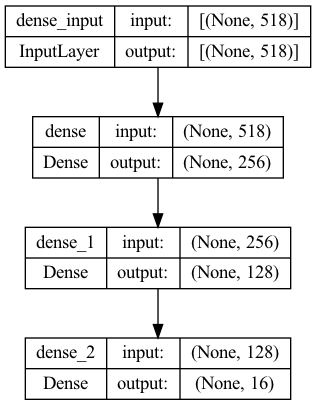

In [101]:
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(518,)))
model.add(Dense(128, activation='relu'))
print(len(y_train[1]))
model.add(Dense(len(y_train[1]), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

keras.utils.plot_model(model, show_shapes=True)

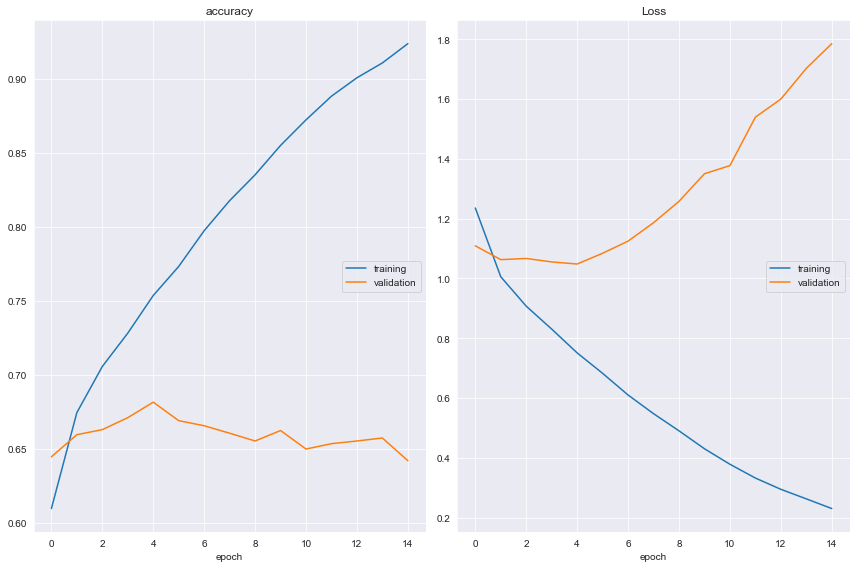

accuracy
	training         	 (min:    0.610, max:    0.924, cur:    0.924)
	validation       	 (min:    0.642, max:    0.682, cur:    0.642)
Loss
	training         	 (min:    0.230, max:    1.236, cur:    0.230)
	validation       	 (min:    1.048, max:    1.786, cur:    1.786)
620/620 [==============================] - 5s 9ms/step - loss: 0.2300 - accuracy: 0.9236 - val_loss: 1.7859 - val_accuracy: 0.6421


In [102]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=64, callbacks=[early_stop, PlotLossesKeras()])

In [107]:
def model_builder(hp):
    model = keras.Sequential()

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    model.add(Dense(256, activation='relu', input_shape=(518,)))
    model.add(Dense(128, activation='relu'))

    model.add(Dense(len(y_train[1]), activation='softmax'))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    return model

tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 01m 14s]
val_accuracy: 0.5812751650810242

Best val_accuracy So Far: 0.6619203686714172
Total elapsed time: 00h 16m 51s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 480 and the optimal learning rate for the optimizer
is 0.001.



In [111]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/10
  14/1240 [..............................] - ETA: 9s - loss: 2.3081 - accuracy: 0.3170 

2022-06-21 12:01:20.311536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1236/1240 [============================>.] - ETA: 0s - loss: 1.2183 - accuracy: 0.6148

2022-06-21 12:01:30.180723: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1240/1240 [==============================] - 11s 9ms/step - loss: 1.2176 - accuracy: 0.6148 - val_loss: 1.1243 - val_accuracy: 0.6397
Epoch 2/10
1240/1240 [==============================] - 10s 8ms/step - loss: 1.0140 - accuracy: 0.6697 - val_loss: 1.0613 - val_accuracy: 0.6629
Epoch 3/10
1240/1240 [==============================] - 10s 8ms/step - loss: 0.9206 - accuracy: 0.6974 - val_loss: 1.0572 - val_accuracy: 0.6673
Epoch 4/10
1240/1240 [==============================] - 10s 8ms/step - loss: 0.8414 - accuracy: 0.7214 - val_loss: 1.0758 - val_accuracy: 0.6663
Epoch 5/10
1240/1240 [==============================] - 10s 8ms/step - loss: 0.7678 - accuracy: 0.7437 - val_loss: 1.0857 - val_accuracy: 0.6694
Epoch 6/10
1240/1240 [==============================] - 10s 8ms/step - loss: 0.6934 - accuracy: 0.7664 - val_loss: 1.1106 - val_accuracy: 0.6690
Epoch 7/10
1240/1240 [==============================] - 10s 8ms/step - loss: 0.6295 - accuracy: 0.7879 - val_loss: 1.1640 - val_accuracy: 0.6

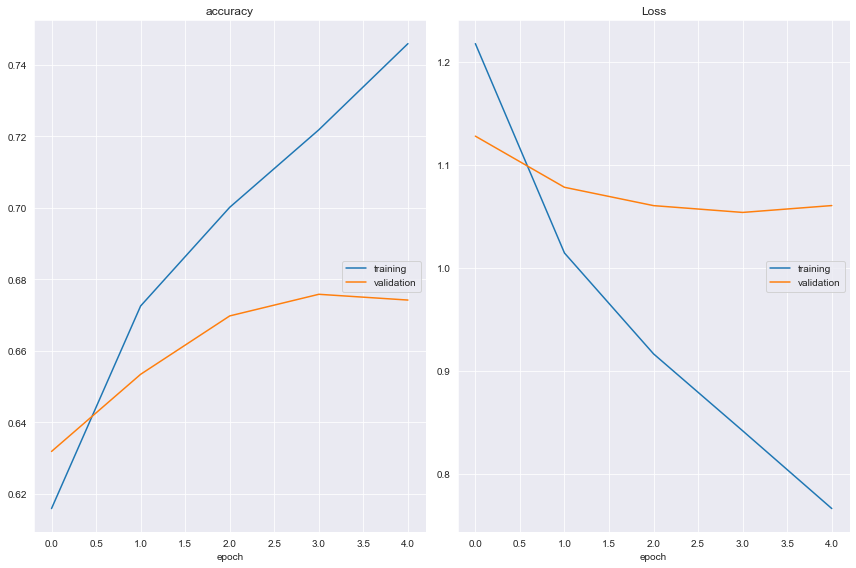

accuracy
	training         	 (min:    0.616, max:    0.746, cur:    0.746)
	validation       	 (min:    0.632, max:    0.676, cur:    0.674)
Loss
	training         	 (min:    0.766, max:    1.217, cur:    0.766)
	validation       	 (min:    1.054, max:    1.128, cur:    1.060)
1240/1240 [==============================] - 11s 9ms/step - loss: 0.7662 - accuracy: 0.7459 - val_loss: 1.0602 - val_accuracy: 0.6742


In [112]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=best_epoch, validation_data=(X_valid, y_valid), callbacks=[PlotLossesKeras()])

<h1>Neural network</h1>

In [27]:
# Split the data in training and remaining dataset
X_train, X_rem, y_train, y_rem = train_test_split(features_df, track_genres, train_size=0.8, random_state=42, stratify=track_genres)

# Split remaining dataset in test and validation
test_size = 0.5
X_valid, X_test, y_valid, y_test = train_test_split(X_rem, y_rem, test_size=0.5)

print(f"Training has {len(X_train), len(y_train)}, Validation has {len(X_valid), len(y_valid)}, Testing has {len(X_test), len(y_test)}")

Training has (39678, 39678), Validation has (4960, 4960), Testing has (4960, 4960)


In [28]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

lab_encoder = LabelEncoder()
lab_encoder.fit(y_train)

y_train = lab_encoder.transform(y_train)
y_valid = lab_encoder.transform(y_valid)
y_test = lab_encoder.transform(y_test)

y_train = tf.keras.utils.to_categorical(y_train)
y_valid = tf.keras.utils.to_categorical(y_valid)
y_test = tf.keras.utils.to_categorical(y_test)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((39678, 518), (39678, 16), (4960, 518), (4960, 16), (4960, 518), (4960, 16))

16
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 256)               132864    
                                                                 
 dense_17 (Dense)            (None, 128)               32896     
                                                                 
 dense_18 (Dense)            (None, 16)                2064      
                                                                 
Total params: 167,824
Trainable params: 167,824
Non-trainable params: 0
_________________________________________________________________


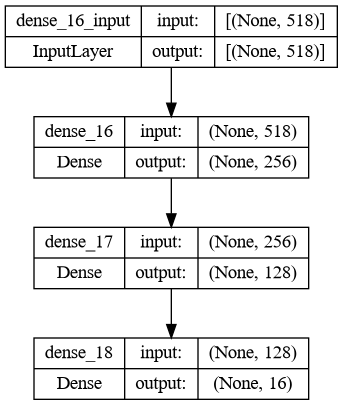

In [29]:
model = Sequential()

model.add(Dense(256, activation='relu', input_shape=(518,)))
model.add(Dense(128, activation='relu'))
print(len(y_train[1]))
model.add(Dense(len(y_train[1]), activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

keras.utils.plot_model(model, show_shapes=True)

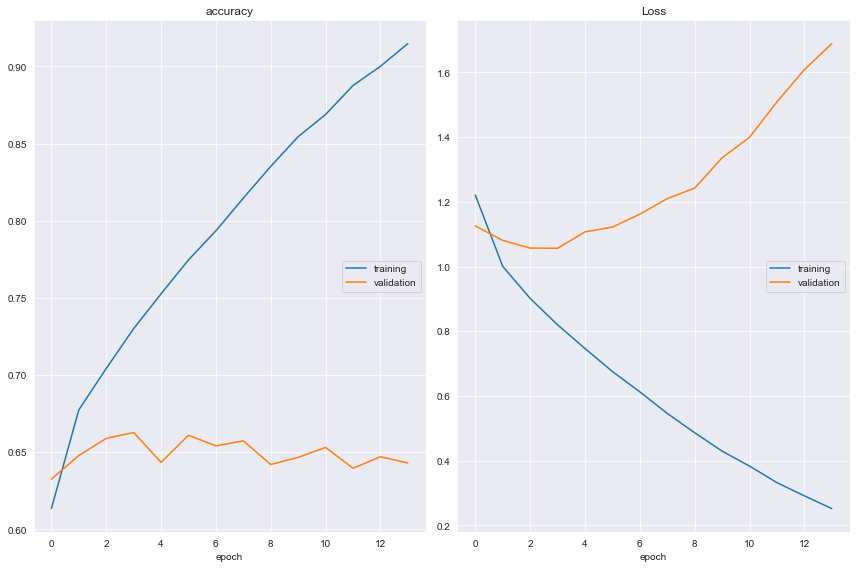

accuracy
	training         	 (min:    0.613, max:    0.915, cur:    0.915)
	validation       	 (min:    0.632, max:    0.663, cur:    0.643)
Loss
	training         	 (min:    0.252, max:    1.221, cur:    0.252)
	validation       	 (min:    1.056, max:    1.689, cur:    1.689)
620/620 [==============================] - 5s 9ms/step - loss: 0.2516 - accuracy: 0.9148 - val_loss: 1.6891 - val_accuracy: 0.6429


In [30]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=10,
                           restore_best_weights=True,
                           mode='min')

history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=50, batch_size=64, callbacks=[early_stop, PlotLossesKeras()])